<a href="https://colab.research.google.com/github/BaishaliChetia/CapsNet-Keras/blob/master/MachineLEarning/ML_models_comparison/ML_models_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import classification_report

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
def svmClassifier(train_features, train_labels, test_features, test_labels):
    svm = SVC()
    svm = svm.fit(train_features, train_labels)
    # predict the class for an unseen example
    results= svm.predict(test_features)
    return metrics.accuracy_score(results, test_labels)
    

def decisionTreeClassifier(train_features, train_labels, test_features, \
                           test_labels):
    tree_clf = tree.DecisionTreeClassifier()
    tree_clf.fit(train_features, train_labels)
    results = tree_clf.predict(test_features)
    return metrics.accuracy_score(results, test_labels)
    

def randomForestClassifier(train_features, train_labels, test_features,\
                           test_labels):
    #rnf = RandomForestClassifier(n_estimators = 100, random_state = 0)
    rnf = RandomForestClassifier(n_estimators=250, random_state=0)
    rnf.fit(train_features, train_labels)
    results = rnf.predict(test_features)
    #print('Random forest without cross_validation',\
                              metrics.accuracy_score(results, test_labels))
    return metrics.accuracy_score(results, test_labels)

def knnClassifier(train_features, train_labels, test_features, test_labels):
    clf = KNeighborsClassifier()
    clf = clf.fit(train_features, train_labels)
    # predict the class for an unseen example
    results= clf.predict(test_features)
    return metrics.accuracy_score(results, test_labels)

In [3]:
def feature_selection_tree(classifier, X, Y):
    #standarizing all data for feature selection
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    train_features, test_features, train_labels, \
    test_labels = model_selection.train_test_split( X, Y, test_size=0.2, \
                                                   random_state=1)
    # creating an extra tree classifier to be used for feature selection
    forest = RandomForestClassifier(n_estimators=250, random_state=2)
    forest.fit(X, Y)
    # importances contains the feature importance value for each metric
    importances = forest.feature_importances_
    # argsort returns the indices that will sort the original array
    sortedIndices = np.argsort(importances)
    # iteratively remove the features with the lowest ranking and record accuracy
    numberOfFeatures = []
    accurClf = []
    
    for num in range(0, 50):
        numberOfFeatures.append(num)
        # obtain indices to delete by slicing the order indices from argsort function
        indicesToDelete = sortedIndices[0:num+1]
        # deleting identified indices
        train_features_new = np.delete(train_features, indicesToDelete, axis = 1)
        test_features_new = np.delete(test_features, indicesToDelete, axis = 1)
        # running the model using updates feature training and test data
        if classifier == 'knn':
            accur = knnClassifier(train_features_new, train_labels, \
                                  test_features_new, test_labels)
        if classifier == 'rnf':
            accur = randomForestClassifier(train_features_new, \
                                           train_labels, test_features_new,\
                                           test_labels)
        if classifier == 'd_tree':
            accur = decisionTreeClassifier(train_features_new, \
                                           train_labels, test_features_new, \
                                           test_labels)
        if classifier == 'svm':
            accur = svmClassifier(train_features_new, train_labels,\
                                  test_features_new, test_labels)
        accurClf.append(accur)
    plt.figure()
    plt.xlabel("Number of features removed")
    plt.ylabel("Cross validation score ")
    plt.plot(numberOfFeatures, accurClf)
    plt.show()

def pipeline_and_crossfoldValidation(classifier, X, Y, train_features, \
                                     train_labels, test_features, test_labels):
    pipe_lr = Pipeline([ ('scl', StandardScaler()),\
                        ('fs', SelectKBest(f_classif, k=110)),('clf', classifier)])
    #pipe_lr = Pipeline([ ('mm', MinMaxScaler()),('clf', classifier)])
    pipe_lr.fit(train_features, train_labels)
    results_predicted = pipe_lr.predict(test_features)
    print("accuracy without cross fold validation for",classifier,"is",\
                     metrics.accuracy_score(results_predicted, test_labels))
    results = cross_val_score(pipe_lr, X, Y, cv = 10)
    print("accuracy with pipeline and 10 fold cross validation for ",\
                                            classifier, "is" ,  results.mean())
    
def gridSearch(classifier, X, Y):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    if classifier == 'knn':
        param_grid = [{'n_neighbors':list(range(3, 40)), 'p':[1, 2, 3, 4, 5]}]
        clf = GridSearchCV(KNeighborsClassifier(), param_grid, \
                           cv = 10, n_jobs = -1)#n_jobs = -1 is for cpu parallelization
    if classifier =='d_tree':
        param_grid = [{'max_depth': [2,4,6,8,10,12], \
                                             'criterion':['gini', 'entropy']}]
        clf = GridSearchCV(tree.DecisionTreeClassifier(), \
                                             param_grid, cv = 10, n_jobs = -1)
    if classifier == 'svm':
        param_grid = [{'kernel': ['rbf', 'linear', 'poly'], 'C':range(1, 15)}]
        clf = GridSearchCV(SVC(), param_grid, cv = 10, n_jobs = -1)
    if classifier == 'rnf':
        param_grid = {'n_estimators':[10, 50, 100, 500], \
                      'max_features': [2, 6, 10, 14]}
        clf = GridSearchCV(RandomForestClassifier(),\
                                               param_grid, cv = 10, n_jobs = -1)
        
    clf.fit(X, Y)
    return clf.best_params_, clf.best_score_

def nestedCV_hyperParaOpt(X, Y, classifier):
    # We use 10 fold as the outer loop for nested CV.
    cv_outer = StratifiedKFold(n_splits =10, random_state =10, shuffle= True)
    results = []
    #This loop sepatates the training and testing data differently every iteration
    for train_indices, test_indices in cv_outer.split(X, Y):
    #separating data into test data and training data pulling out the idices
        x_train, x_test = X.iloc[train_indices, :], X.iloc[test_indices, :]
        y_train, y_test = Y.iloc[train_indices], Y.iloc[test_indices]
    
        #inner cross fold validation loop that separtes the 
        #validation set from the test set
        cv_inner = StratifiedKFold(n_splits = 10, \
                                   random_state = 10, shuffle = True)
       
        if classifier == 'rnf':
            param_grid = {'n_estimators':[10, 50, 100, 500], \
                                                'max_features': [2, 6, 10, 14]}
            grid_search = GridSearchCV(RandomForestClassifier(random_state= 0),\
                          param_grid, scoring='accuracy', cv = cv_inner , \
                          refit=True, n_jobs=-1)#n_jobs = -1 is for cpu parallelization
        if classifier == 'knn':
            param_grid = [{'n_neighbors':list(range(3, 40)), 'p':[1, 2, 3, 4, 5]}]
            grid_search= GridSearchCV(KNeighborsClassifier(),\
                          param_grid, scoring='accuracy', cv = cv_inner ,\
                           refit=True, n_jobs = -1)#n_jobs = -1 is for cpu parallelization
        if classifier =='d_tree':
            param_grid = [{'max_depth': [2,4,6,8,10,12], \
                                           'criterion':['gini', 'entropy']}]
            grid_search = GridSearchCV(tree.DecisionTreeClassifier(), \
                                       param_grid, scoring='accuracy', \
                                       cv = cv_inner , refit=True, n_jobs = -1)
        if classifier == 'svm':
            param_grid = [{'kernel': ['rbf', 'linear', 'poly'], 'C':range(1, 15)}]
            grid_search = GridSearchCV(SVC(), param_grid, \
                       scoring='accuracy', cv = cv_inner , refit=True, n_jobs = -1)
        
        result = grid_search.fit(x_train, y_train)
        #returning the best performing model configuration fit on all training set
        best_model = result.best_estimator_
        #evaluation of the best model on original test set
        accuracy = best_model.score(x_test, y_test)
        #append the accuracy for each iteration of the outer loop
        results.append(accuracy)
        print("Best result: ", accuracy, "with parameter", result.best_params_)
    #get the average accuracy of the ten iterations of the outer loop
    print("Overall accuracy:", np.mean(results))


def learning_curve_generator(classifier, X,Y ):
    #learning curve generated using the best parameters after hyper-parameter optimization
    if classifier == 'knn':
        estimator = KNeighborsClassifier(n_neighbors=3, p = 1)
    if classifier == 'rnf':
        #best features picked from nested cross-validtion and hyper-parameter optimization
        estimator = RandomForestClassifier(n_estimators= 500, max_features= 6)
    if classifier == 'd_tree':
        #best features picked from nested cross-validtion and hyper-parameter optimization
        estimator = tree.DecisionTreeClassifier(max_depth=12, criterion= 'gini') 
    if classifier == 'svm':
        estimator = SVC(C= 13, kernel= 'rbf')
    title = "Learning Curve"
    plt.title(title)
    ylim=(0.0, 1.01)
    plt.ylim(ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes1=np.linspace(.05, 1.0, 10)
    custom_cv = ShuffleSplit(n_splits=30, test_size=0.1, random_state=0)
    train_sizes, train_scores, test_scores = learning_curve(estimator,\
                                X, Y, train_sizes=train_sizes1, cv = custom_cv)
            
    # remember axis = 1 operates on the horizontal axis and calculates the mean below for      
   # each row. Each row corresponds to one tick and each value returned in a row refer to the 
    # accuracy for that fold. 
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.grid()
    
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", \
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", \
             label="Cross-validation score")
    
    plt.legend(loc="best")
    plt.show()

def performance_metrics(X, Y, classifier):
    pipe_lr = Pipeline([('scl', StandardScaler()), ('clf', classifier)])
    predicted_labels = cross_val_predict(pipe_lr, X, Y, cv = 10)
    print(classification_report(Y, y_pred = predicted_labels))


        

In [ ]:

# open the data file 
#data = np.genfromtxt("dataset-sat.csv", delimiter=",")
data = \
pd.read_csv("https://raw.githubusercontent.com/BaishaliChetia/MyProjects/main/MachineLearning/ML_models_comparison/dataset-sat.csv",\
                                                               delimiter = ',')

# split the data into training and class data
Y = data.iloc[:, 1]
X = data.iloc[:, 2:]



# Basic Evaluation

In [36]:
"""BASIC EVALUATION"""
train_features,test_features, train_labels, test_labels =\
      model_selection.train_test_split(X , Y , test_size =0.3, random_state =3)
accurknn = knnClassifier(train_features, train_labels, test_features, test_labels)
print("Basic evaluation accuracy for knn", accurknn)
accurrnf = randomForestClassifier(train_features, train_labels, test_features, test_labels)
print("Basic evaluation accuracy Random Forest", accurrnf)
accurD_tree = decisionTreeClassifier(train_features, train_labels, test_features, test_labels)
print ("Basic evaluation accuracy decision tree", accurD_tree)
accurSVM = svmClassifier(train_features, train_labels, test_features, test_labels)
print ("Basic evaluation accuracy SVM", accurSVM)
print("--"*80) 

Basic evaluation accuracy for knn 0.5942857142857143
Basic evaluation accuracy Random Forest 0.7714285714285715
Basic evaluation accuracy decision tree 0.7628571428571429
Basic evaluation accuracy SVM 0.4657142857142857
----------------------------------------------------------------------------------------------------------------------------------------------------------------


# Feature Selection

See plot for Tree-based feature-selection result 


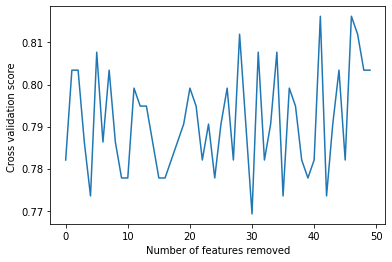

----------------------------------------------------------------------------------------------------
plot for SVM based feature-selection result 


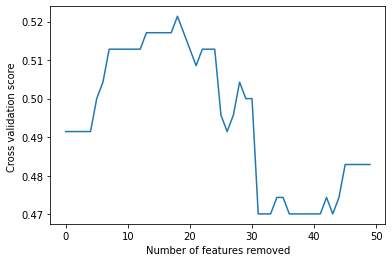

----------------------------------------------------------------------------------------------------
Random Forest feature-selection result 


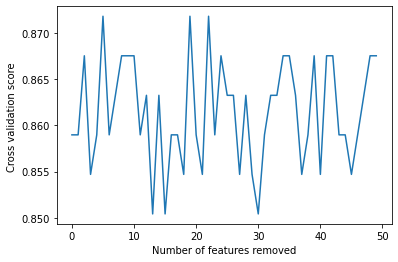

----------------------------------------------------------------------------------------------------
k-nearest-neigbor feature-selection result 


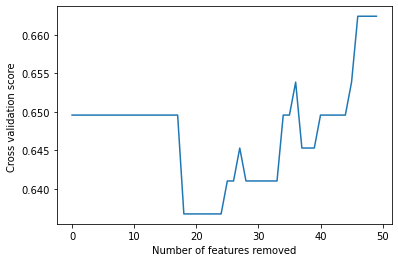

----------------------------------------------------------------------------------------------------


In [19]:
    """TREE BASED FEATURE SELECTION"""
    print("See plot for Tree-based feature-selection result ")
    ##feature selection for decision tree
    feature_selection_tree('d_tree', X, Y)
    print("--"*50)
    #feature selection for SVM
    print("plot for SVM based feature-selection result ")
    feature_selection_tree('svm', X, Y)
    print("--"*50)
    #feature selection for random forest
    print("Random Forest feature-selection result ")
    feature_selection_tree('rnf', X, Y)
    print("--"*50)
    #feature selection for knn
    print("k-nearest-neigbor feature-selection result ")
    feature_selection_tree( 'knn', X, Y)
    print("--"*50)

    

# PIPELINE(STANDARDIZATION &  UNIVARIATE FEATURE SELECTION ) AND CROSS_FOLD_VALIDATION

In [20]:
knn_clf = KNeighborsClassifier()
rnf_clf = RandomForestClassifier()
d_tree_clf = tree.DecisionTreeClassifier()
svm_clf = SVC()
print("--"*50)
pipeline_and_crossfoldValidation(d_tree_clf, X, Y, train_features, train_labels, test_features, test_labels)
pipeline_and_crossfoldValidation(knn_clf, X, Y, train_features, train_labels, test_features, test_labels)
pipeline_and_crossfoldValidation(rnf_clf, X, Y, train_features, train_labels, test_features, test_labels)
pipeline_and_crossfoldValidation(svm_clf, X, Y, train_features, train_labels, test_features, test_labels)
print("--"*50)
    

----------------------------------------------------------------------------------------------------
accuracy without cross fold validation for DecisionTreeClassifier() is 0.7428571428571429
accuracy with pipeline and 10 fold cross validation for  DecisionTreeClassifier() is 0.7015915119363395
accuracy without cross fold validation for KNeighborsClassifier() is 0.5885714285714285
accuracy with pipeline and 10 fold cross validation for  KNeighborsClassifier() is 0.5720306513409961
accuracy without cross fold validation for RandomForestClassifier() is 0.7571428571428571
accuracy with pipeline and 10 fold cross validation for  RandomForestClassifier() is 0.7307618626584145
accuracy without cross fold validation for SVC() is 0.4657142857142857
accuracy with pipeline and 10 fold cross validation for  SVC() is 0.44941791924550545
----------------------------------------------------------------------------------------------------


# HYPER PARAMETER OPTIMISATION

In [21]:
 
print("HYPER-PARAMETER OPTIMIZATION")
#Random Forest 
best_param, best_score = gridSearch('rnf', X, Y)
print("Random Forest best parameters are: ", best_param, "and  best accuracy \
                       score after hyper parameter optimization: ", best_score)


HYPER-PARAMETER OPTIMIZATION
Random Forest best parameters are:  {'max_features': 2, 'n_estimators': 100} and  best accuracy score after hyper parameter optimization:  0.7436486884762747
----------------------------------------------------------------------------------------------------


In [22]:

#for decision tree hyper_parameter optimisation
best_param, best_score = gridSearch('d_tree', X, Y)
print("Decision tree best parameters are: ", best_param, "and  best \
accuracy score after hyper parameter optimization: ", best_score)

Decision tree best parameters are:  {'criterion': 'gini', 'max_depth': 12} and  best accuracy score after hyper parameter optimization:  0.693847627468317
----------------------------------------------------------------------------------------------------


In [24]:
#for SVM hyperparameter tuning
best_param, best_score = gridSearch('svm', X, Y)
print("SVM best parameters are: ", best_param, "and best accuracy \
            score after hyper parameter optimization: ", best_score)
print("--"*50)

SVM best parameters are:  {'C': 13, 'kernel': 'rbf'} and best accuracy             score after hyper parameter optimization:  0.5652298850574712
----------------------------------------------------------------------------------------------------


# NESTED CROSSFOLD VALIDATION AND HYPER_PARAMETER OPTIMIZATION.

In [ ]:
""" Commented out because computaionally intensive and time consuming. Please 
    see the pdf report for the results"""
    ##Random Forest
    #nestedCV_hyperParaOpt(X, Y, 'rnf')
    
    ##Decision Tree
    #nestedCV_hyperParaOpt(X, Y, 'd_tree')
    
    ##KNN
    #nestedCV_hyperParaOpt(X, Y, 'knn')
    
    ##SVM
    #nestedCV_hyperParaOpt(X, Y, 'svm')

# Learning Curve Analysis

Learning-curve, SVM


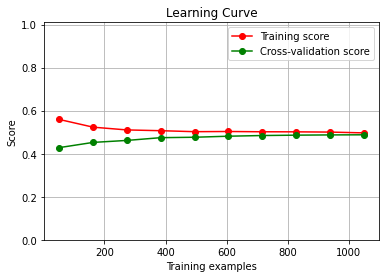

In [25]:
#SVM
print("Learning-curve, SVM")
learning_curve_generator('svm', X,Y)

Learning-curve, SVM


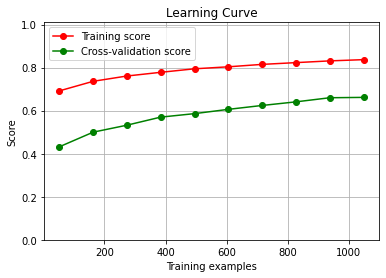

In [26]:
#KNN
print("Learning-curve, SVM")
learning_curve_generator('knn', X,Y)

Learning-curve, Decision Tree


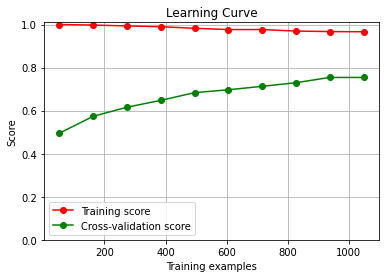

In [28]:
#Decision Tree
print("Learning-curve, Decision Tree")
learning_curve_generator('d_tree', X,Y)

In [ ]:
#Random Forest, check report for result
print("Learning-curve, Random forest")
learning_curve_generator('rnf', X,Y)

# Performance Metrics

In [30]:
##Random Forest
print("Performance Metrics, Random Forest")
performance_metrics(X, Y, rnf_clf)


Performance Metrics, Random Forest
              precision    recall  f1-score   support

           0       0.70      0.68      0.69       347
           1       0.74      0.63      0.68       325
           2       0.76      0.85      0.80       494

    accuracy                           0.74      1166
   macro avg       0.73      0.72      0.72      1166
weighted avg       0.74      0.74      0.73      1166



In [31]:
#SVM
print("Performance Metrics, SVM")
performance_metrics(X, Y, svm_clf)

Performance Metrics, SVM
              precision    recall  f1-score   support

           0       0.40      0.28      0.33       347
           1       0.48      0.16      0.24       325
           2       0.52      0.85      0.65       494

    accuracy                           0.49      1166
   macro avg       0.47      0.43      0.41      1166
weighted avg       0.47      0.49      0.44      1166



In [32]:
#Decision Tree
print("Performance Metrics, Decision Tree")
performance_metrics(X, Y, d_tree_clf)

Performance Metrics, Decision Tree
              precision    recall  f1-score   support

           0       0.66      0.67      0.67       347
           1       0.68      0.65      0.67       325
           2       0.77      0.78      0.77       494

    accuracy                           0.71      1166
   macro avg       0.70      0.70      0.70      1166
weighted avg       0.71      0.71      0.71      1166



In [33]:
#KNN
print("Performance Metrics, KNN")
performance_metrics(X, Y, knn_clf)

Performance Metrics, KNN
              precision    recall  f1-score   support

           0       0.50      0.52      0.51       347
           1       0.49      0.46      0.47       325
           2       0.69      0.70      0.69       494

    accuracy                           0.58      1166
   macro avg       0.56      0.56      0.56      1166
weighted avg       0.58      0.58      0.58      1166

